[View in Colaboratory](https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tensorflow/fashion_mnist_resnet.ipynb)

# Fashion MNIST with Keras and Resnet

Adapted from 
* https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb
* https://github.com/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [0]:
# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
# We can not hold very many images in memory
NUMBER_OF_SAMPLES = 10000

In [0]:
x_train_samples = x_train[:NUMBER_OF_SAMPLES]

In [0]:
y_train_samples = y_train[:NUMBER_OF_SAMPLES]

In [0]:
import skimage.data
import skimage.transform

x_train_224 = np.array([skimage.transform.resize(image, (224, 224)) for image in x_train_samples])

In [10]:
x_train_224.shape

(10000, 224, 224, 1)

## Alternative: ResNet
* basic ideas
  * depth does matter
  * 8x deeper than VGG
  * possible by using shortcuts and skipping final fc layer
  * prevents vanishing gradient problem
* https://keras.io/applications/#resnet50
* https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba

http://arxiv.org/abs/1512.03385
![Deep Learning](https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/residual.png)

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(classes=6, weights=None, input_shape=(196, 196, 1))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
BATCH_SIZE=10
EPOCHS = 10

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
%time history = model.fit(x_train_224, y_train_samples, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
6440/8000 [=======================>......] - ETA: 1:07 - loss: nan - acc: 0.0925

# Checking our results (inference)

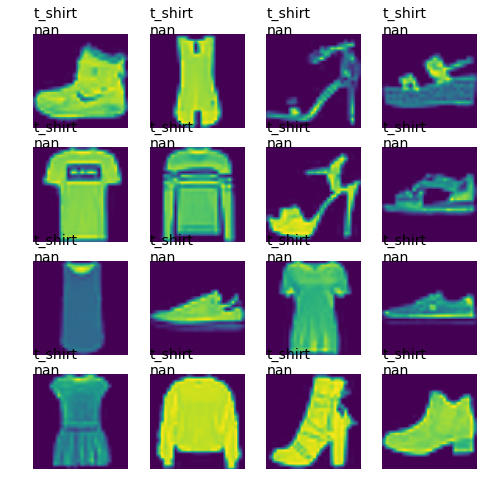

In [0]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_train_224[:16]), 
                 model.predict(x_train_224[:16]))

# Not bad!